In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
# 定义绘图的参数
# plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['mathtext.fontset']='cm'
plt.style.use('tableau-colorblind10')
# 定义尺寸
mm = 1/25.4 # inch 和 毫米的转换
# plt.savefig('../img/imgname',dpi=600,format='pdf',bbox_inches = 'tight')
df=pd.read_csv('../data/Rainfall_data.csv')
df.head()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

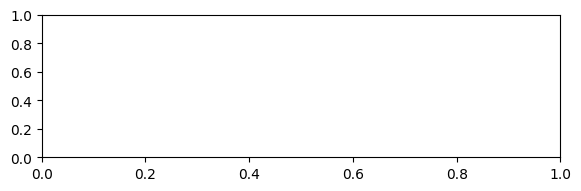

In [4]:
plt.figure(figsize=(170*mm, 160*mm))
plt.subplot(3,1,1)
length=len(df)
plt.plot(list(range(length)),df['Relative Humidity'])
plt.ylabel('Relative Humidity (%)',fontsize=10)
plt.subplot(3,1,2)
plt.plot(list(range(length)),df['Temperature'])
plt.ylabel('Temperature ($^\circ$C)',fontsize=10)
plt.subplot(3,1,3)
plt.plot(list(range(length)),df['Precipitation'])
plt.ylabel('Precipitation (mm)',fontsize=10)

本文希望利用LSTM实现时间序列数据的预测，这里首先对但变量的precipitation进行预测，主要的pipeline如下：
1. 数据预处理，归一化的操作
2. 制作torch的dataset，dataloader
3. 定义模型，利用torch.nn来定义
4. 进行训练
5. 实现推理

In [5]:
#  对数据进行归一化处理
scaler = StandardScaler()
df['Relative Humidity'] = scaler.fit_transform(df['Relative Humidity'].values.reshape(-1,1))
df['Temperature'] = scaler.fit_transform(df['Temperature'].values.reshape(-1,1))
df['Precipitation'] = scaler.fit_transform(df['Precipitation'].values.reshape(-1,1))
df.head()


,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,-1.100551,1.158401,-0.651415
1,2000,2,1,8.73,-0.952341,1.447517,-0.651068
2,2000,3,1,8.48,-1.411446,1.576858,-0.651383
3,2000,4,1,13.79,-0.669815,0.939282,-0.651352
4,2000,5,1,17.40,0.209607,0.418874,0.202674


In [6]:
#  利用torch制作dataset
import torch
from torch.utils.data import Dataset, DataLoader

# Defining a function that creates sequences and targets as shown above
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
    '''
    df: Pandas DataFrame of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(df)
    for i in range(L-tw):
        # Option to drop target from dataframe
        if drop_targets:
            df.drop(target_columns, axis=1, inplace=True)
            # Get current sequence 
        sequence = df[i:i+tw][target_columns].values
        # Get values right after the current sequence
        target = df[i+tw:i+tw+pw][target_columns].values
        data[i] = {'sequence': sequence, 'target': target}
    return data

class SeqDataset(Dataset):
    def __init__(self,df):
        self.data=df
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        sample=self.data[idx]
        return torch.Tensor(sample['sequence']),torch.Tensor(sample['target'])

In [7]:
Batch_size=16
split=0.8
train_data=generate_sequences(df,4,1,['Precipitation'])
dataset=SeqDataset(train_data)

In [8]:
# Split the data according to our split ratio and load each subset into a
# separate DataLoader object
from torch.utils.data import random_split
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=Batch_size, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=Batch_size, shuffle=True, drop_last=True)

In [9]:
# 利用lstm训练模型，预测未来的precipitation
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

inputsize=4
hiddensize=100
outputsize=1
num_layers=4
num_epochs=100
learning_rate=0.001

class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(1,len(input_seq),-1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM(inputsize, hiddensize, outputsize)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for seq, labels in trainloader:
        optimizer.zero_grad()

        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if epoch%10==0:
        print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')

# Test the model
model.eval()
with torch.no_grad():
    for seq, labels in testloader:
        model.hidden_cell = (torch.zeros(num_layers, len(seq), model.hidden_layer_size),
                            torch.zeros(num_layers, len(seq), model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        print(f'loss: {single_loss.item():10.8f}')
        

/home/step/anaconda3/envs/xclds/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.78011686
epoch:  10 loss: 0.80255353
epoch:  20 loss: 0.68099797
epoch:  30 loss: 1.01493740
epoch:  40 loss: 1.10628855
epoch:  50 loss: 0.35658062
epoch:  60 loss: 2.06483865
epoch:  70 loss: 1.24258602
epoch:  80 loss: 0.62307501
epoch:  90 loss: 1.21144509
loss: 0.67049915
loss: 0.68500841
loss: 1.18322372


In [10]:
# 做推理
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            predictions.append(p)
            print(p.shape)
            actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions.squeeze(), actuals

train_dataDL = DataLoader(dataset, batch_size=Batch_size, shuffle=False, drop_last=True)
y_pred,y_true=make_predictions_from_dataloader(model, train_dataDL)


torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


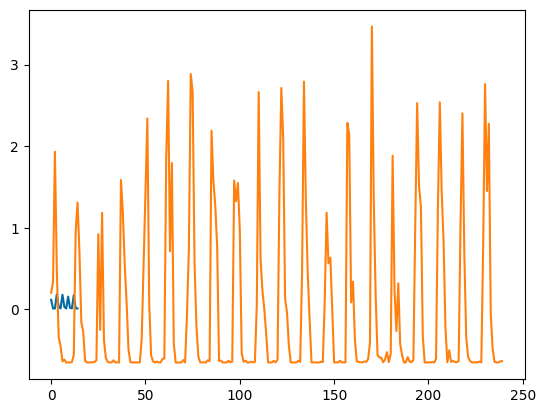

In [11]:
plt.plot(list(range(len(y_pred))),y_pred)
plt.plot(list(range(len(y_true))),y_true)